<a href="https://colab.research.google.com/github/navas604/Text-Mining-Image-Recognition/blob/main/HDT4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Universidad Galileo**
## **Maestría en Data Science**
## **Text Mining & Image Recognition**
## **Antonio Everardo Navas Contreras, 14003163**
## **29/08/2021**

---

## **HOJA DE TRABAJO 4**

---

### CARGAR LIBRERÍAS

In [1]:
import pandas as pd
import spacy
import numpy as np
import re
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

### MODELOS DE LENGUAJE

In [2]:
!python -m spacy download es_core_news_sm

     |████████████████████████████████| 16.2 MB 7.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


In [3]:
import pkg_resources, imp
imp.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.7/dist-packages/pkg_resources/__init__.py'>

In [4]:
nlp_en = spacy.load('en_core_web_sm')
nlp_es = spacy.load("es_core_news_sm")

### CARGAR EL DATASET

In [5]:
URL = 'training.1600000.processed.noemoticon.csv'
tweets_DF = pd.read_csv(URL, encoding='latin-1', usecols=[2, 4, 5] , names=['Timestamp', 'Username', 'Content'])
tweets_DF.head()

,Timestamp,Username,Content
0,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
2,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
3,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
4,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
################################################### BORRAR ###################################################
#tweets_DF = tweets_DF.head(1000)

In [7]:
tweets_DF.shape

(1600000, 3)

### TOP 3 USUARIOS MAS POPULARES (MENCIONADOS)

In [8]:
pattern = re.compile(r'@\w+')

mentions = pd.DataFrame(sum([pattern.findall(x) for x in tweets_DF.Content],[])).value_counts().rename_axis('Mentions').reset_index(name='Counts')
top_3_mentions = mentions[:3]

print('Los 3 usuarios más populares son:\n')
top_3_mentions

Los 3 usuarios más populares son:



,Mentions,Counts
0,@mileycyrus,4500
1,@tommcfly,3887
2,@ddlovato,3467


### CORPUS

In [9]:
top_3_list = []
for user in range(len(top_3_mentions)):
  user_data = tweets_DF.loc[tweets_DF.Content.str.contains(top_3_mentions.Mentions[user])]
  user_data = user_data.reindex(columns = ['Content', 'Username', 'Timestamp'])
  user_data['Tweet_Length'] = user_data.Content.str.len() - len(top_3_mentions.Mentions[user] + ' ')
  top_3_list.append(user_data)

In [10]:
top_user1 = pd.DataFrame(top_3_list[0])
top_user1

,Content,Username,Timestamp,Tweet_Length
1021,@mileycyrus hahaha dont be like that one time ...,kristenn_lynn,Mon Apr 06 23:30:57 PDT 2009,95
2014,"@mileycyrus i have the same problem, but it's ...",nathiuria,Tue Apr 07 00:45:20 PDT 2009,125
2073,@mileycyrus I guess counting sheep didn't work...,amyamoore,Tue Apr 07 00:49:07 PDT 2009,60
2080,@mileycyrus I would too if it meant spending a...,xdokkenx,Tue Apr 07 00:49:44 PDT 2009,88
2156,@mileycyrus AWWW u seriously have the cutest d...,XFearLessX,Tue Apr 07 00:56:41 PDT 2009,100
...,...,...,...,...
1595291,Hey @mileycyrus I voted for you at the teen ch...,rumours12,Tue Jun 16 06:52:58 PDT 2009,92
1596796,@mileycyrus http://twitpic.com/7f5fy - I love ...,Maddeeeeee,Tue Jun 16 07:31:21 PDT 2009,100
1597905,@mileycyrus i see the photos of your KISS iss ...,LizzMartin,Tue Jun 16 07:55:55 PDT 2009,62
1598348,@mileycyrus i am definitley definitley getting...,lucyannedixon,Tue Jun 16 08:04:20 PDT 2009,127


In [11]:
top_user2 = pd.DataFrame(top_3_list[1])
top_user2

,Content,Username,Timestamp,Tweet_Length
1690,@tommcfly hey saw u guys play @ pushover..didn...,mcsteph94,Tue Apr 07 00:19:09 PDT 2009,128
1789,@tommcfly Good morning Tom! Why can't I send y...,mcflyholland,Tue Apr 07 00:26:52 PDT 2009,121
2514,@tommcfly did you know that johnsons baby use ...,ckstarlet,Tue Apr 07 01:23:07 PDT 2009,86
3029,"@dougiemcfly @tommcfly good morning guys, how ...",McFLYBelgium,Tue Apr 07 02:03:41 PDT 2009,98
3524,"@tommcfly hey, no chance of adding brighton or...",lilmissvik,Tue Apr 07 02:46:02 PDT 2009,121
...,...,...,...,...
1594946,@tommcfly you should record Star Girl with JB,Sarah_1991,Tue Jun 16 06:46:41 PDT 2009,36
1595131,@tommcfly why you at the studio then? just wa...,hannyb90,Tue Jun 16 06:50:40 PDT 2009,115
1595194,@tommcfly Gonna make a trip to England in the ...,JulesK_7,Tue Jun 16 06:50:59 PDT 2009,61
1597053,@tommcfly Heya Tom! You should follow Peter Fa...,rosiebasketcase,Tue Jun 16 07:37:16 PDT 2009,92


In [12]:
top_user3 = pd.DataFrame(top_3_list[2])
top_user3

,Content,Username,Timestamp,Tweet_Length
460,@ddlovato @David_Henrie ummmmm i cant find it.,toritor11,Mon Apr 06 22:51:34 PDT 2009,37
573,@ddlovato Do you hate us?? Please don't,lovatolover,Mon Apr 06 22:58:30 PDT 2009,30
7032,@ddlovato Wish that i could see it.. Thats th...,mariapersson,Tue Apr 07 07:02:58 PDT 2009,86
7089,"@ddlovato hey demi, wen are you and selena gon...",xxBEJEALOUSxx,Tue Apr 07 07:05:11 PDT 2009,69
8611,@ddlovato ahhhh i wish i could go to the dalla...,Julie_Dances,Fri Apr 17 20:31:31 PDT 2009,75
...,...,...,...,...
1592766,@ddlovato hope to see you soon,bogart17,Tue Jun 16 06:00:23 PDT 2009,21
1593103,Fell asleep to @chasecoy and woke up to @ddlov...,amazinglyalex,Tue Jun 16 06:06:42 PDT 2009,72
1593330,@ddlovato I VOTED!! =]]] can't wait,chasing_lights,Tue Jun 16 06:12:27 PDT 2009,26
1597791,FINALLY 15 TOMORROW And @MirandaBuzz @jennette...,quagmire1794,Tue Jun 16 07:52:11 PDT 2009,107


### NORMALIZACIÓN DE TEXTO

In [13]:
def normalizacion(corpus):
  newCorpus = []
  for doc in corpus:
      #newCorpus.append(re.sub(r'[^@\w+a-zA-Z0-9\s{1}áéíóúüñÁÉÍÓÚ]', '', doc).lower().strip().rstrip('\n').rstrip('\r\n'))
      temp = re.sub(r'@\w+', '', doc).lower().strip().rstrip('\n').rstrip('\r\n')
      newCorpus.append(re.sub(r'[^a-zA-Z0-9\s{1}áéíóúüñÁÉÍÓÚ]', '', temp))
  return newCorpus

In [14]:
corpus1 = top_user1.Content
corpus2 = top_user2.Content
corpus3 = top_user3.Content

In [15]:
corpus1 = normalizacion(corpus1)
corpus1

['hahaha dont be like that one time in ny when you got 30 mins of sleep then got sick  love you',
 'i have the same problem but its 443 here lets see if counting works123456 57 58 132 133 134 no zs for me',
 'i guess counting sheep didnt work  hope you get some sleep',
 'i would too if it meant spending a day in heaven wmy mom and getting to see her again',
 'awww u seriously have the cutest dog miley sorry your not with her now  hope u get some sleep xoxo',
 'httptwitpiccom2xszg  napping at this point you may need a few of those gma is gonna come early',
 'where did you find that quote no dont answer better sleep xoxo from germany where its already morning  ',
 'httptwitpiccom2y606  i want a sofie  shes helllza cute',
 'ouch mine too',
 'dude i have to go on a 4 mile run in cold ass boston after waking up just now this sucks',
 'aww i feel u u just woke up for school  hopefully ill meet u today hah lt3',
 'awe i feel u i just woke up for school  hopefully we both have a better rest of

In [16]:
corpus2 = normalizacion(corpus2)
corpus2

['hey saw u guys play  pushoverdidnt get 2 meet u tho cuz of th huge line  i was very upset  lola msg would make up 4 it',
 'good morning tom why cant i send you a message this is too short for the question i have  well to bad for me i guess',
 'did you know that johnsons baby use animals like cute bunnies to test their products',
 'good morning guys how are you all you know its frustrating i never get a reply',
 'hey no chance of adding brighton or eastbourne to the ucap tour gutted im missing out this time round  i love you guys',
 'have fun tom i need to buy eclipse too but i have no money sad timess',
 'are you coming to play at plymouth again this year cus i cant go to the ucap tour cus you arent coming anywhere near me  oxo',
 'o starbucks never tehe oooh now i want one',
 'aw i want a starbucks',
 'i have to still read eclipse as well dont watch twilight the movie though if you want to keep liking the books movies bad',
 'httptwitpiccom3iquy  i miss your old hairstyle daniel  bu

In [17]:
corpus3 = normalizacion(corpus3)
corpus3

['ummmmm i cant find it',
 'do you hate us please dont',
 'wish that i could see it  thats the downside of living in sweden good luck anyway',
 'hey demi wen are you and selena gonna do another video i miss them',
 'ahhhh i wish i could go to the dallas showbut i wont be near there then',
 'i just saw your tour dates and now i am sadyou come to houston two days before i get home from vacation',
 'sonny with a chance in the uk only 6 more days i cant wait but ill miss it im at the mcfly concert  hmm  ill record it',
 'demii how is your stage going to be i dont know what kind of seats to look for when i buy them on tuesdayy',
 'hi demi at which airport in germany were you if you were in munich i missed you by like a day  if youd answer thatll be grea',
 'awww why omg i really wana c ure new show but it is not out here',
 'hey demi why do you not come to austria',
 'whyy is not my fault my parents are busy for 1th time  i feel upset  u',
 'hihow long are you in london i have uni lectures 

### TOKENIZACIÓN

In [18]:
def tokenizacion(corpus):
  newCorpus = []
  for doc in corpus:
      newCorpus.append(nlp_en(doc))
  return newCorpus

In [19]:
corpus1 = tokenizacion(corpus1)
corpus1

[hahaha dont be like that one time in ny when you got 30 mins of sleep then got sick  love you,
 i have the same problem but its 443 here lets see if counting works123456 57 58 132 133 134 no zs for me,
 i guess counting sheep didnt work  hope you get some sleep,
 i would too if it meant spending a day in heaven wmy mom and getting to see her again,
 awww u seriously have the cutest dog miley sorry your not with her now  hope u get some sleep xoxo,
 httptwitpiccom2xszg  napping at this point you may need a few of those gma is gonna come early,
 where did you find that quote no dont answer better sleep xoxo from germany where its already morning  ,
 httptwitpiccom2y606  i want a sofie  shes helllza cute,
 ouch mine too,
 dude i have to go on a 4 mile run in cold ass boston after waking up just now this sucks,
 aww i feel u u just woke up for school  hopefully ill meet u today hah lt3,
 awe i feel u i just woke up for school  hopefully we both have a better rest of the day amp i hope tha

In [20]:
corpus2 = tokenizacion(corpus2)
corpus2

[hey saw u guys play  pushoverdidnt get 2 meet u tho cuz of th huge line  i was very upset  lola msg would make up 4 it,
 good morning tom why cant i send you a message this is too short for the question i have  well to bad for me i guess,
 did you know that johnsons baby use animals like cute bunnies to test their products,
 good morning guys how are you all you know its frustrating i never get a reply,
 hey no chance of adding brighton or eastbourne to the ucap tour gutted im missing out this time round  i love you guys,
 have fun tom i need to buy eclipse too but i have no money sad timess,
 are you coming to play at plymouth again this year cus i cant go to the ucap tour cus you arent coming anywhere near me  oxo,
 o starbucks never tehe oooh now i want one,
 aw i want a starbucks,
 i have to still read eclipse as well dont watch twilight the movie though if you want to keep liking the books movies bad,
 httptwitpiccom3iquy  i miss your old hairstyle daniel  but you still look grea

In [21]:
corpus3 = tokenizacion(corpus3)
corpus3

[ummmmm i cant find it,
 do you hate us please dont,
 wish that i could see it  thats the downside of living in sweden good luck anyway,
 hey demi wen are you and selena gonna do another video i miss them,
 ahhhh i wish i could go to the dallas showbut i wont be near there then,
 i just saw your tour dates and now i am sadyou come to houston two days before i get home from vacation,
 sonny with a chance in the uk only 6 more days i cant wait but ill miss it im at the mcfly concert  hmm  ill record it,
 demii how is your stage going to be i dont know what kind of seats to look for when i buy them on tuesdayy,
 hi demi at which airport in germany were you if you were in munich i missed you by like a day  if youd answer thatll be grea,
 awww why omg i really wana c ure new show but it is not out here,
 hey demi why do you not come to austria,
 whyy is not my fault my parents are busy for 1th time  i feel upset  u,
 hihow long are you in london i have uni lectures during your show on wedne

### REMOVER STOPWORDS

In [22]:
def removeStops(corpus):
  newCorpus = []
  for doc in corpus:
    s = ""
    for token in doc:
      if(token.is_stop == False):
        s = s + token.text + " "
    newCorpus.append(s.strip())
  return newCorpus

In [23]:
corpus1 = removeStops(corpus1)
corpus1

['hahaha nt like time ny got 30 mins sleep got sick   love',
 'problem 443 lets counting works123456 57 58 132 133 134 zs',
 'guess counting sheep nt work   hope sleep',
 'meant spending day heaven wmy mom getting',
 'awww u seriously cutest dog miley sorry   hope u sleep xoxo',
 'httptwitpiccom2xszg   napping point need gma gon na come early',
 'find quote nt answer better sleep xoxo germany morning',
 'httptwitpiccom2y606   want sofie   s helllza cute',
 'ouch',
 'dude 4 mile run cold ass boston waking sucks',
 'aww feel u u woke school   hopefully ill meet u today hah lt3',
 'awe feel u woke school   hopefully better rest day amp hope includes meeting u lol',
 'wow early start nt bed hope tummy feel better soon   love aussie fan   xxx',
 'come reply',
 'aww   chin hun',
 'god blizzard',
 'good luck wish thereee',
 'goood luck today   g m     love state',
 'school ugh',
 'billy rays new album fantastic m listening itunes d buy aus   come',
 'tyra watch online nt uk nt think',
 'miley

In [24]:
corpus2 = removeStops(corpus2)
corpus2

['hey saw u guys play   pushoverdidnt 2 meet u tho cuz th huge line   upset   lola msg 4',
 'good morning tom nt send message short question   bad guess',
 'know johnsons baby use animals like cute bunnies test products',
 'good morning guys know frustrating reply',
 'hey chance adding brighton eastbourne ucap tour gutted m missing time round   love guys',
 'fun tom need buy eclipse money sad timess',
 'coming play plymouth year cus nt ucap tour cus nt coming near   oxo',
 'o starbucks tehe oooh want',
 'aw want starbucks',
 'read eclipse nt watch twilight movie want liking books movies bad',
 'httptwitpiccom3iquy   miss old hairstyle daniel   look great',
 'hoping love amsterdam enjoy sunbathing lol cloudy america',
 'wish d guys',
 'awww   coming going star trek premier xx',
 'feel sad nt travel guys amsterdam   come norway soon',
 'awww ve trying   played radio   playing u',
 'know love brazil country   m jealous love',
 'hope ll come germany day like guys live day',
 'gon na come s

In [25]:
corpus3 = removeStops(corpus3)
corpus3

['ummmmm nt find',
 'hate nt',
 'wish   s downside living sweden good luck',
 'hey demi wen selena gon na video miss',
 'ahhhh wish dallas showbut wo nt near',
 'saw tour dates sadyou come houston days home vacation',
 'sonny chance uk 6 days nt wait ill miss m mcfly concert   hmm   ill record',
 'demii stage going nt know kind seats look buy tuesdayy',
 'hi demi airport germany munich missed like day   d answer ll grea',
 'awww omg wana c ure new',
 'hey demi come austria',
 'whyy fault parents busy 1th time   feel upset   u',
 'hihow long london uni lectures wednesday',
 'u know messages',
 'miss toooooooo   xoxo',
 'hey demi come austria   yeah wish good flight',
 'hey demi come austria   yeah wish good flight',
 'ilove ou demi great',
 'wish reply mee',
 'wish coming toronto',
 'wish concert',
 'fruckin luv u lt3333    ur funny ur xd wish meet u person',
 'germany toobaumholder   seen celebrity concert cept lil jon',
 'hate   lol',
 'thinks   come belgium',
 'roflll nt dead talk   

### STEMMING Y LEMMATIZATION

In [26]:
def stemmingLemmating(corpus):
  documents = tokenizacion(corpus)
  newCorpus = []
  for doc in documents:
    s = ""
    for token in doc:
      s = s + token.lemma_ + " "
    newCorpus.append(s.strip())
  return newCorpus

In [27]:
corpus1 = stemmingLemmating(corpus1)
corpus1

['hahaha nt like time ny get 30 min sleep get sick    love',
 'problem 443 let count works123456 57 58 132 133 134 z',
 'guess count sheep nt work    hope sleep',
 'meant spend day heaven wmy mom get',
 'awww u seriously cut dog miley sorry    hope u sleep xoxo',
 'httptwitpiccom2xszg    napping point need gma gon na come early',
 'find quote nt answer better sleep xoxo germany morning',
 'httptwitpiccom2y606    want sofie    s helllza cute',
 'ouch',
 'dude 4 mile run cold ass boston wake suck',
 'aww feel u u wake school    hopefully ill meet u today hah lt3',
 'awe feel u wake school    hopefully well rest day amp hope include meet u lol',
 'wow early start nt bed hope tummy feel better soon    love aussie fan    xxx',
 'come reply',
 'aww    chin hun',
 'god blizzard',
 'good luck wish thereee',
 'goood luck today    g m      love state',
 'school ugh',
 'billy ray new album fantastic m listen itunes d buy aus    come',
 'tyra watch online nt uk nt think',
 'miley tummy hurt head h

In [28]:
corpus2 = stemmingLemmating(corpus2)
corpus2

['hey see u guy play    pushoverdidnt 2 meet u tho cuz th huge line    upset    lola msg 4',
 'good morning tom nt send message short question    bad guess',
 'know johnsons baby use animal like cute bunny test product',
 'good morning guy know frustrating reply',
 'hey chance add brighton eastbourne ucap tour gutte m miss time round    love guy',
 'fun tom nee buy eclipse money sad timess',
 'come play plymouth year cus nt ucap tour cus nt come near    oxo',
 'o starbucks tehe oooh want',
 'aw want starbuck',
 'read eclipse nt watch twilight movie want like book movie bad',
 'httptwitpiccom3iquy    miss old hairstyle daniel    look great',
 'hope love amsterdam enjoy sunbathe lol cloudy america',
 'wish d guy',
 'awww    come go star trek premier xx',
 'feel sad nt travel guy amsterdam    come norway soon',
 'awww ve try    play radio    play u',
 'know love brazil country    m jealous love',
 'hope will come germany day like guy live day',
 'gon na come sweden    x',
 'hey tommy conc

In [29]:
corpus3 = stemmingLemmating(corpus3)
corpus3

['ummmmm nt find',
 'hate nt',
 'wish    s downside live sweden good luck',
 'hey demi wen selena gon na video miss',
 'ahhhh wish dallas showbut wo nt near',
 'see tour date sadyou come houston days home vacation',
 'sonny chance uk 6 day nt wait ill miss m mcfly concert    hmm    ill record',
 'demii stage go nt know kind seat look buy tuesdayy',
 'hi demi airport germany munich miss like day    d answer will grea',
 'awww omg wana c ure new',
 'hey demi come austria',
 'whyy fault parent busy 1th time    feel upset    u',
 'hihow long london uni lecture wednesday',
 'u know message',
 'miss toooooooo    xoxo',
 'hey demi come austria    yeah wish good flight',
 'hey demi come austria    yeah wish good flight',
 'ilove ou demi great',
 'wish reply mee',
 'wish come toronto',
 'wish concert',
 'fruckin luv u lt3333     ur funny ur xd wish meet u person',
 'germany toobaumholder    see celebrity concert cept lil jon',
 'hate    lol',
 'think    come belgium',
 'roflll nt dead talk    w

### PALABRAS REPRESENTATIVAS

In [30]:
def listToString(s):
    strX = ""
    for palabra in s:
        strX = strX + palabra + " "
    return strX

In [31]:
def rep_words(strCorpus, k):
  #strCorpus = listToString(corpus).split()
  most_common = pd.DataFrame(Counter(strCorpus.split()).most_common(k), columns=['Word', 'Count'])
  return most_common

In [32]:
k = 15

In [33]:
strCorpus1 = listToString(corpus1)
rep_words(strCorpus1, k)

,Word,Count
0,love,912
1,miley,836
2,nt,819
3,u,647
4,m,590
5,good,501
6,vote,371
7,come,327
8,s,296
9,hope,288


In [34]:
strCorpus2 = listToString(corpus2)
rep_words(strCorpus2, k)

,Word,Count
0,nt,795
1,tom,688
2,m,462
3,love,461
4,come,373
5,good,352
6,u,344
7,xx,304
8,guy,274
9,x,271


In [35]:
strCorpus3 = listToString(corpus3)
rep_words(strCorpus3, k)

,Word,Count
0,nt,761
1,love,630
2,demi,579
3,m,530
4,u,446
5,come,367
6,s,289
7,good,258
8,wish,256
9,hope,245


### WORDCLOUD

In [36]:
def word_cloud(strCorpus, username, k):
  stopwords = set(STOPWORDS)

  wordcloud = WordCloud(width = 800, height = 800,
                        background_color ='white',
                        stopwords = stopwords,
                        max_words = k,
                        min_font_size = 10).generate(strCorpus)

  # Plot WordCloud image					
  #plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.title('WORDCLOUD DE ' + username + '\n', fontdict={"fontsize":20, "color":"red", "fontweight":"bold"}) 
  plt.axis("off")
  plt.tight_layout(pad = 0)

  plt.show()

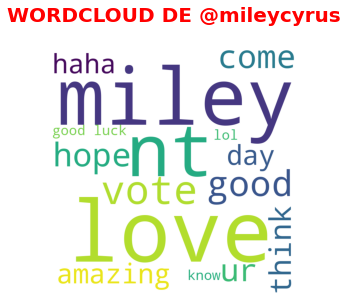

In [37]:
word_cloud(strCorpus1, top_3_mentions.Mentions[0], k)

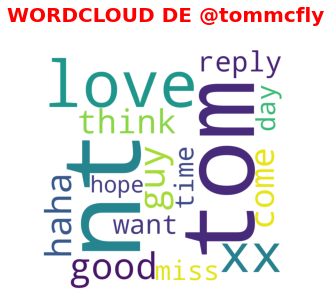

In [38]:
word_cloud(strCorpus2, top_3_mentions.Mentions[1], k)

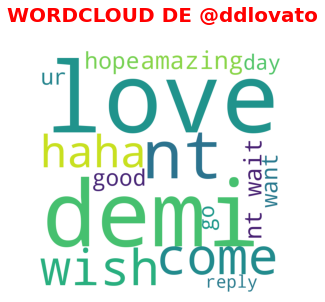

In [39]:
word_cloud(strCorpus3, top_3_mentions.Mentions[2], k)